# Introduction

Set up the environment and read the corresponding input file

In [3]:
input_path = "../output/cc_results.json"

In [4]:
import json
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


with open(input_path) as f:
    data = json.load(f)

## Outcome distribution

First, count the number of successful outcomes. These are training instances for which we found a path connecting both endpoints using the product of information extraction.

In [5]:
def is_successful(item): 
        return 'Successful' in item[1] 

successes = [item for item in data.items() if is_successful(item)]

display(Markdown("### Successes"))
print("%i successes out of %i" % (len(successes), len(data)))
display(Markdown("---"))

### Successes

22707 successes out of 43738


---

Second, the instances were no path was found. Here, IE didn't yield the data to populate a knowledge graph with elements connecting the endpoints of the search

In [6]:
def no_path(item):
    return 'NoPath' == item[1]

no_paths = [item for item in data.items() if no_path(item)]

display(Markdown("### No path found"))
print("Instances with no connecting path: %i out of %i" % (len(no_paths), len(data)))
display(Markdown("---"))

### No path found

Instances with no connecting path: 4332 out of 43738


---

Finally, the instances with errors. On these, the inference procedure had an unrecoverable error that could potentially be fixed

In [7]:
def error(item):
    return 'Error' in item[1]

errors = [item for item in data.items() if error(item)]

display(Markdown("### Instances with error"))
print("%i out of %i" % (len(errors), len(data)))

### Instances with error

16699 out of 43738


We should also take a look to see the kind of errors and their distribution

In [8]:
s_errors = pd.Series(e[1]['Error'].split()[0] for e in errors)

display(pd.DataFrame(s_errors.value_counts(), columns=["Num of Instances"]))

,Num of Instances
org.ml4ai.inference.NotGroundableElementException:,14625
org.ml4ai.inference.SameGroundedEndpointsException,2074


_SameGroundedEndpointsException_ happens when both endpoints end being grounded to the same entity, as an artifact of the entity linking procedure being used in the code. The share is relatively small.

On the other hand, _NotGroundableElementException_ happens when one (or both) of the endpoints can't be linked to any of the nodes of the knowledge graph. The share is large, therefore, this is a large opportunity surface

---

# Successful outcomes analysis

Create a data frame as a basis of this analysis

In [9]:
frame = pd.DataFrame({'Key':s[0], 'Path':s[1]['Successful']} for s in successes)

## Analize path lengths

We are interested on the number of edges contained in a path $P$ (Symbollicaly called $|P|$). This is the number of _hops_ of a "reasoning". By definition, paths with a single edge only require one document to be read, therefore, are not as valuable to us. 
Documents with multiple hops _may_ require multiple documents to be assembled. The path lenght represents an _upper bound_ for the dataset's size.

In [10]:
# Each instance may have more than one path connecting the endpoints. 
# This is an artifact of the entity-linking procedue: each endpoint may have multiple goundings, hence multiple paths
# In that case, the most efficient path is that with the shortest length, which is found right here:
frame['PathLength'] = frame.Path.apply(lambda ps: min(len(p) for p in ps))

frame.PathLength.value_counts()

2     10019
1      7261
3      3750
4      1158
5       359
6       120
7        25
8         9
9         3
10        2
13        1
Name: PathLength, dtype: int64

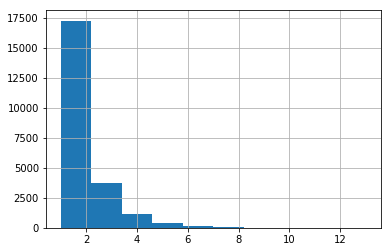

In [11]:
frame.PathLength.hist()
plt.show()

**TODO:** Fix this histogram

---

## Analize the minimum number of required documents 

Similarly to the previous section. We can compute the minimal set of documents $D$ required to find a path $P$.

The upper-bound to $|D|$ is given by $|P|$. Consider the case in which, for each edge $e_i \in P$, the set of documents that _back_ the relation encoded it, $A(e_i)$ (the _attributing documents of_ $e_i$). If the attributing documents of all edges are disjoint: $\bigcap_{e_i \in P}A(e_i) = \emptyset$ then every element in the cartesian product of all attributing document sets _has_ cardinality $|P|$.

A consequence of this, is that there can be more than one minimal set of documents $D$. This situation happens if one edge is contained in more than one document. It follows that there is a set of minimal sets of documents $D \in \mathcal{D}$.

The lower-bound is given by $1$. If $|P| = 1$, this condition meets tivially: Every member of $A(e_1)$ is a minimal set of documents. When there is more than one edge in $P$, this condition is met if all $A(e_i)$ intersect pair-wise. Consider $I$ to be the intersection of all $A(e_i)$ when they all intersect paiwise. Any individual member of $I$ is itself a minimal set of documents.

In [12]:
def num_documents(paths):
    '''
    This function computes the size of minimal set of documents for each path containes in the argument.
    Then it returns the smallest size.
    '''
    def helper(l, r, total):
        cum = l | r
        if len(l & r) > 0:
            return (cum, total)
        else:
            return (cum, total + 1)
        
    totals = list()
        
    for path in paths:
        doc_sets = [{a['Doc'] for a in edge['Attributions']} for edge in path]
        if len(doc_sets) == 1:
            totals.append(1)
        else:
            sumation = 1
            current = doc_sets[0]
            for n in doc_sets[1:]:
                current, sumation = helper(current, n, sumation)
            totals.append(sumation)
    
    return min(totals)

frame['MinDocs'] = frame.Path.apply(num_documents)

frame.MinDocs.value_counts()

2     10661
1      8056
3      3069
4       718
5       159
6        39
8         2
7         2
11        1
Name: MinDocs, dtype: int64

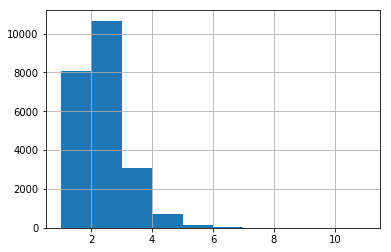

In [13]:
frame.MinDocs.hist()
plt.show()

---